In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score

import seaborn as sns
import matplotlib.pyplot as plt

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## Fault type identification
There are 10 types of faults, linked to each bearing deffect:

- **Ball_007_1**: Ball defect (0.007 inch)
- **Ball_014_1**: Ball defect (0.014 inch)
- **Ball_021_1**: Ball defect (0.021 inch)
- **IR_007_1**: Inner race fault (0.007 inch)
- **IR_014_1**: Inner race fault (0.014 inch)
- **IR_021_1**: Inner race fault (0.021 inch)
- **Normal_1**: Normal
- **OR_007_6_1**: Outer race fault (0.007 inch, data collected from 6 O'clock position)
- **OR_014_6_1**: Outer race fault (0.014 inch, 6 O'clock)
- **OR_021_6_1**: Outer race fault (0.021 inch, 6 O'clock)

## Get the data
The file we will read is the result of preprocessing the raw data files (folder `/kaggle/input/cwru-bearing-datasets/raw/`).

Time series segments contains 2048 points each. Given that the sampling frequency is 48kHz each time serie covers 0.04 seconds.

In [ ]:
data_time = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/archive (6)/feature_time_48k_2048_load_1.csv")
data_time

,max,min,mean,sd,rms,skewness,kurtosis,crest,form,fault
0,0.35986,-0.41890,0.017840,0.122746,0.124006,-0.118571,-0.042219,2.901946,6.950855,Ball_007_1
1,0.46772,-0.36111,0.022255,0.132488,0.134312,0.174699,-0.081548,3.482334,6.035202,Ball_007_1
2,0.46855,-0.43809,0.020470,0.149651,0.151008,0.040339,-0.274069,3.102819,7.376926,Ball_007_1
3,0.58475,-0.54303,0.020960,0.157067,0.158422,-0.023266,0.134692,3.691097,7.558387,Ball_007_1
4,0.44685,-0.57891,0.022167,0.138189,0.139922,-0.081534,0.402783,3.193561,6.312085,Ball_007_1
...,...,...,...,...,...,...,...,...,...,...
2295,0.21425,-0.19839,0.010769,0.064100,0.064983,-0.212497,-0.119312,3.297037,6.034174,Normal_1
2296,0.21967,-0.20882,0.013136,0.068654,0.069883,-0.061308,-0.295122,3.143410,5.319958,Normal_1
2297,0.20799,-0.21613,0.012571,0.067128,0.068279,-0.154754,-0.071405,3.046161,5.431299,Normal_1
2298,0.21425,-0.22405,0.012608,0.066813,0.067977,-0.326966,0.023662,3.151821,5.391672,Normal_1


## Split into train and test datasets

In [ ]:
train_data, test_data = train_test_split(data_time, test_size = 750, stratify = data_time['fault'], random_state = 1234)
test_data['fault'].value_counts()

,count
fault,
OR_007_6_1,75
IR_014_1,75
OR_014_6_1,75
OR_021_6_1,75
Normal_1,75
IR_021_1,75
Ball_014_1,75
Ball_007_1,75
Ball_021_1,75


## Scale features in train set

In [ ]:
# Scale each column to have zero mean and standard deviation equal to 1
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data.iloc[:,:-1])
pd.DataFrame(train_data_scaled).describe()

,0,1,2,3,4,5,6,7,8
count,1.550000e+03,1.550000e+03,1.550000e+03,1.550000e+03,1.550000e+03,1.550000e+03,1.550000e+03,1.550000e+03,1.550000e+03
mean,1.260640e-16,1.002782e-16,-2.888012e-16,6.016693e-17,-5.386372e-17,1.833659e-17,-5.500976e-17,4.950878e-16,-2.521281e-17
std,1.000323e+00,1.000323e+00,1.000323e+00,1.000323e+00,1.000323e+00,1.000323e+00,1.000323e+00,1.000323e+00,1.000323e+00
min,-8.877055e-01,-2.951564e+00,-1.935376e+00,-9.258092e-01,-9.231913e-01,-5.951422e+00,-7.874742e-01,-1.481163e+00,-7.775653e-01
25%,-7.088474e-01,-3.753614e-01,-6.908705e-01,-6.755048e-01,-6.760659e-01,-3.678525e-01,-6.073122e-01,-8.064817e-01,-6.475107e-01
50%,-4.958143e-01,5.113022e-01,-3.141526e-01,-5.055027e-01,-5.038108e-01,2.140248e-01,-4.182916e-01,-2.135605e-01,-4.548003e-01
75%,4.477234e-01,7.003484e-01,4.560105e-01,7.015641e-01,7.003255e-01,5.823124e-01,2.860828e-01,5.648177e-01,4.360429e-01
max,3.297226e+00,8.671141e-01,3.503861e+00,2.980548e+00,2.981995e+00,4.906756e+00,6.349353e+00,4.049712e+00,9.629399e+00


In [ ]:
test_data_scaled = (test_data.iloc[:,:-1].values - scaler.mean_)/np.sqrt(scaler.var_)
pd.DataFrame(test_data_scaled).describe()

,0,1,2,3,4,5,6,7,8
count,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000
mean,-0.013718,0.003277,-0.018151,-0.013327,-0.013375,-0.035946,0.018838,0.009379,-0.012433
std,0.976752,0.993896,1.003708,0.987301,0.987315,1.105931,1.028360,0.998996,0.936491
min,-0.895968,-2.754539,-1.590184,-0.922087,-0.922953,-6.014935,-0.759377,-1.515700,-0.772309
25%,-0.706453,-0.429163,-0.720867,-0.677965,-0.678545,-0.355683,-0.606352,-0.762882,-0.641796
50%,-0.494044,0.503185,-0.303458,-0.492809,-0.490457,0.224657,-0.415267,-0.219297,-0.452940
75%,0.394936,0.704214,0.401811,0.669274,0.667916,0.576534,0.294171,0.547845,0.447909
max,3.008545,0.861398,3.003970,2.885914,2.887282,6.301407,5.007205,3.784107,3.531440


## Train a model using Support Vector Classifier
Call the SVC() model from sklearn and fit the model to the training data.

In [ ]:
from sklearn.svm import SVC

In [ ]:
svc_model = SVC()
svc_model.fit(train_data_scaled, train_data['fault'])

SVC()

## Model Evaluation
Now get predictions from the model and create a confusion matrix and a classification report.

In [ ]:
train_predictions = svc_model.predict(train_data_scaled)
test_predictions = svc_model.predict(test_data_scaled)

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

Plot confusion matrixes.

In [ ]:
train_confu_matrix = confusion_matrix(train_data['fault'], train_predictions)
test_confu_matrix = confusion_matrix(test_data['fault'], test_predictions)

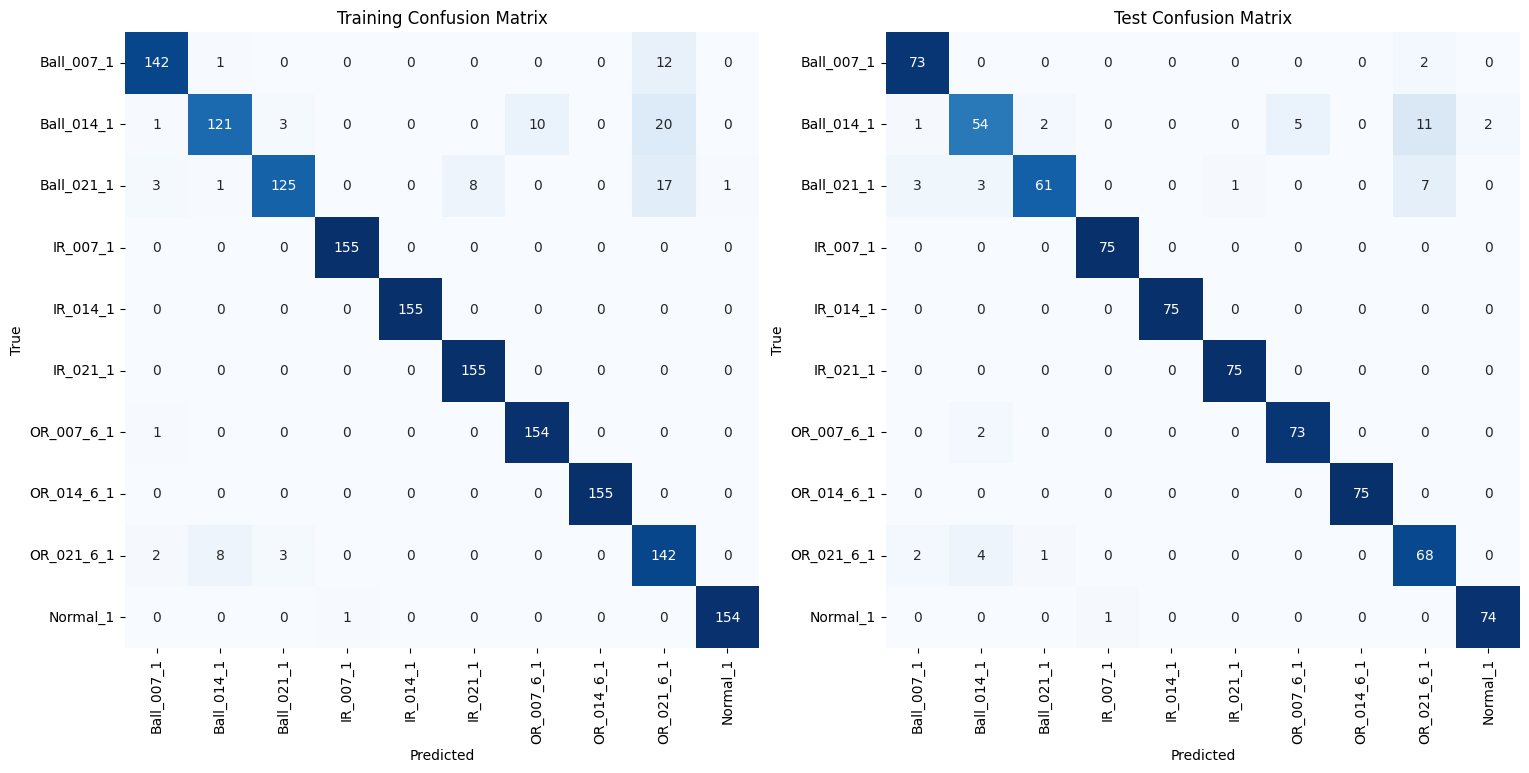

In [ ]:
fault_type = data_time.fault.unique()

plt.figure(1,figsize=(18,8))

plt.subplot(121)
sns.heatmap(train_confu_matrix, annot= True,fmt = "d",
xticklabels=fault_type, yticklabels=fault_type, cmap = "Blues", cbar = False)
plt.title('Training Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.subplot(122)

plt.subplot(122)
sns.heatmap(test_confu_matrix, annot = True,
xticklabels=fault_type, yticklabels=fault_type, cmap = "Blues", cbar = False)
plt.title('Test Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.show()

In [ ]:
# Classification report (test set)
class_report = classification_report(y_pred = test_predictions, y_true = test_data['fault'])
print(class_report)

              precision    recall  f1-score   support

  Ball_007_1       0.92      0.97      0.95        75
  Ball_014_1       0.86      0.72      0.78        75
  Ball_021_1       0.95      0.81      0.88        75
    IR_007_1       0.99      1.00      0.99        75
    IR_014_1       1.00      1.00      1.00        75
    IR_021_1       0.99      1.00      0.99        75
    Normal_1       0.94      0.97      0.95        75
  OR_007_6_1       1.00      1.00      1.00        75
  OR_014_6_1       0.77      0.91      0.83        75
  OR_021_6_1       0.97      0.99      0.98        75

    accuracy                           0.94       750
   macro avg       0.94      0.94      0.94       750
weighted avg       0.94      0.94      0.94       750

